# Airbnb
## - Questions to answer
- Can we predict price?
- Can we predict review ratings?
- Can we get insights from the above two to condense into a helpful list? (Plus anything eles we might notice along the way?

In [55]:
###import all here 
import pandas as pd
import requests
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import nltk
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeRegressor
import re 
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
%matplotlib inline
###grab data straight from url
#url="http://data.insideairbnb.com/united-kingdom/england/london/2018-11-04/data/listings.csv.gz"
###note the csv is compressed due to size
#listings = pd.read_csv(url, compression="gzip")


In [2]:
###what size of data are we dealing with?
listings.shape

(74815, 96)

# Step 1 - Exploration for the purpose of cleaning the data

In [3]:
###we can almost certainly drop some of these columns 
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [4]:
###the first thing i want to do is get rid of any listings that haven't yet been reviewed - the presumption being that these may not have the historical data
listings.dropna(subset=['first_review'], inplace=True)
listings.drop(columns=['first_review'], inplace= True)

In [5]:
###look at the proportion of nulls in columns 
listings.isnull().mean()[listings.isnull().mean()>0].sort_values(ascending=False)

jurisdiction_names              1.000000
neighbourhood_group_cleansed    1.000000
medium_url                      1.000000
xl_picture_url                  1.000000
host_acceptance_rate            1.000000
thumbnail_url                   1.000000
license                         0.998668
square_feet                     0.993462
monthly_price                   0.908041
weekly_price                    0.876026
notes                           0.557972
host_response_rate              0.384021
host_response_time              0.383932
interaction                     0.382013
host_about                      0.375884
house_rules                     0.366468
access                          0.349661
neighborhood_overview           0.331272
security_deposit                0.328252
transit                         0.323029
space                           0.260846
host_neighbourhood              0.237732
state                           0.236684
cleaning_fee                    0.221938
neighbourhood   

In [6]:
###From looking down this list I can already see quite a few columns to drop either because they have no bearing , are represented elsewhere, or are empty
dropcols = ['id', 'scrape_id', 'last_scraped', 'experiences_offered', 'host_id', 
           'host_name', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_group_cleansed', 
           'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'license', 
           'jurisdiction_names', 'square_feet', 'weekly_price', 'monthly_price', 'host_location',
           'calendar_updated', 'last_review','host_acceptance_rate']
listings.drop(columns=dropcols, inplace=True)

In [7]:
listings.shape

(56286, 73)

In [8]:
##not going to be doing any analysis using URL
listings.drop(columns=list(x for x in listings.columns if 'url' in x), inplace=True)

In [9]:
###take a look at object columns 
obj_cols = listings.select_dtypes(include='object')
obj_cols

,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,...,price,security_deposit,cleaning_fee,extra_people,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,"Cozy, 3 minutes to Piccadilly Line",PLEASE CONTACT ME BEFORE BOOKING Homely apartm...,"Hello people, This is a bright, comfortable ro...",PLEASE CONTACT ME BEFORE BOOKING Homely apartm...,Details to follow..,NaN,details to follow when i get a chance..,"Kitchen, small dining / smoking room (if you s...",Depends on what else I have on.. It is always ...,"If you smoke, please do so only in the little ...",...,$35.00,NaN,$7.00,$15.00,f,f,f,strict_14_with_grace_period,t,f
1,The Sanctuary,The room has a double bed and a single foldawa...,This Listing is for The Sanctury The accommoda...,The room has a double bed and a single foldawa...,"Ealing Broadway, as short walk from our place ...",NaN,extemely good transport links to central londo...,Huge family kitchen and good wifi,We give everyone a great welcome and make sure...,We don't allow alcohol or takeaways,...,$70.00,NaN,NaN,$35.00,f,t,f,strict_14_with_grace_period,f,f
2,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,...,$55.00,$100.00,$15.00,$15.00,f,f,f,moderate,f,f
3,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Open from June 2018 after a 3-year break, we a...",Ready again from June 2018 for bookings after ...,"Open from June 2018 after a 3-year break, we a...","Location, location, location! You won't find b...",This property has new flooring throughout. Gue...,You can walk to tourist London or take numerou...,Full use of whole independent apartment,"Always available by email or phone (before, du...",The apartment benefits from new flooring throu...,...,$300.00,$350.00,$65.00,$10.00,f,f,f,strict_14_with_grace_period,f,f
4,Battersea 2 bedroom house & parking,"Artist house, high ceiling bedrooms, private p...",- End of terrace two bedroom house close to So...,"Artist house, high ceiling bedrooms, private p...","- Battersea is a quiet family area, easy acces...",- Please have a profile or tell us more about ...,"- 5 mins walk to Battersea Park, 15 mins walk ...",- there is a communal garden in our complex - ...,We rent out our house only when we are away. T...,A house manual will be emailed once a booking ...,...,$150.00,$250.00,$70.00,$15.00,f,f,f,strict_14_with_grace_period,t,t
5,All-comforts 2-bed flat near Wimbledon tennis,"Large, all comforts, 2-bed flat; first floor; ...",10 mins walk to Southfields tube and Wimbledon...,"Large, all comforts, 2-bed flat; first floor; ...",This is a leafy residential area with excellen...,Non-smokers only. No pets.,Free off-street parking; buses to Richmond/Too...,Entire flat; use of communal gardens.,I'm happy to provide you with any helpful hint...,No smoking. No parties. No loud music after 10...,...,$65.00,$250.00,$50.00,$11.00,f,f,f,moderate,f,f
6,Clean big Room in London (Room 1),Big room with double bed/ clean sheets/ clean ...,Big double Room to let up to 6 months or more....,Big room with double bed/ clean sheets/ clean ...,Barnet is one of the largest boroughs in Londo...,Please read rules book on arrival,Brent Cross station 7 minutes away Heathrow is...,Fully equipped kitchen/ upstairs bathroom/ dow...,daily,Guests can use the kitchen at any time as long...,...,$29.00,$100.00,$0.00,$8.00,f,t,f,strict_14_with_grace_period,f,f
7,FREE WIFI!! Angel Bright Apt with Private Terrace,Contemporary design meets classic Londo

In [10]:
### a number of columns contain free text - we will drop them
free_text = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 
             'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_about']
###save them in a seperate df in case we want to investigate later
textdf = listings.copy()[free_text]

listings.drop(columns=free_text, inplace=True)

In [11]:
###take a look what's left - with the goal being to convert as many as possible to numeric for prediction purposes
listings.select_dtypes(include='object')

,host_since,host_response_time,host_response_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,city,...,price,security_deposit,cleaning_fee,extra_people,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,2009-08-14,within an hour,100%,t,"['email', 'phone', 'manual_online', 'reviews',...",t,f,"London, United Kingdom",Haringey,London,...,$35.00,NaN,$7.00,$15.00,f,f,f,strict_14_with_grace_period,t,f
1,2009-09-22,within a day,75%,f,"['email', 'phone', 'facebook', 'reviews', 'wor...",t,f,"Ealing, Greater London, United Kingdom",Ealing,Ealing,...,$70.00,NaN,NaN,$35.00,f,t,f,strict_14_with_grace_period,f,f
2,2009-11-16,within an hour,100%,f,"['email', 'phone', 'facebook', 'reviews']",t,f,"Islington, Greater London, United Kingdom",Islington,Islington,...,$55.00,$100.00,$15.00,$15.00,f,f,f,moderate,f,f
3,2010-01-04,NaN,NaN,t,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, Fitzrovia, United Kingdom",Westminster,London,...,$300.00,$350.00,$65.00,$10.00,f,f,f,strict_14_with_grace_period,f,f
4,2009-09-28,within a few hours,100%,f,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Wandsworth,London,...,$150.00,$250.00,$70.00,$15.00,f,f,f,strict_14_with_grace_period,t,t
5,2010-04-03,within an hour,100%,t,"['email', 'phone', 'reviews']",t,f,"Wimbledon, London, United Kingdom",Wandsworth,Wimbledon,...,$65.00,$250.00,$50.00,$11.00,f,f,f,moderate,f,f
6,2010-04-05,within a few hours,90%,f,"['email', 'phone', 'reviews', 'offline_governm...",t,f,"Barnet, England, United Kingdom",Barnet,Barnet,...,$29.00,$100.00,$0.00,$8.00,f,t,f,strict_14_with_grace_period,f,f
7,2010-04-19,NaN,NaN,f,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Islington, England, United Kingdom",Islington,Islington,...,$150.00,$150.00,$74.00,$10.00,f,f,f,strict_14_with_grace_period,f,f
8,2010-04-25,NaN,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Kensington, Greater London, United Kingdom",Kensington and Chelsea,Kensington,...,$75.00,$200.00,$25.00,$0.00,f,f,f,moderate,f,f
9,2010-05-06,within a day,100%,t,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"London, England, United Kingdom",Tower Hamlets,London,...,$50.00,$0.00,$25.00,$15.00,f,f,f,strict_14_with_grace_period,t,t


In [12]:
### location data will restrict to cleansed neighbourhood and potentially postcode 
location =  ['street', 'city', 'state', 'market', 'smart_location', 'longitude', 'latitude']
listings.drop(columns=location, inplace=True)

In [13]:
##removing the $ from price field 
cols=['price','cleaning_fee','extra_people','security_deposit']
listings[cols]=listings[cols].replace('[\$,]', '', regex=True).astype(float)

In [14]:
###removing the % from host response
cols=['host_response_rate']
listings[cols]=listings[cols].replace('[\%,]', '', regex=True).astype(float)

In [15]:
listings.shape

(56286, 47)

In [16]:
###check nulls 
listings.isnull().mean()[listings.isnull().mean()>0].sort_values(ascending=False)

host_response_rate             0.384021
host_response_time             0.383932
security_deposit               0.328252
cleaning_fee                   0.221938
review_scores_value            0.029741
review_scores_location         0.029652
review_scores_checkin          0.029617
review_scores_accuracy         0.028444
review_scores_communication    0.028355
review_scores_cleanliness      0.028142
review_scores_rating           0.027289
zipcode                        0.025761
bathrooms                      0.001066
beds                           0.000959
bedrooms                       0.000515
host_total_listings_count      0.000231
host_listings_count            0.000231
host_is_superhost              0.000231
host_has_profile_pic           0.000231
host_identity_verified         0.000231
host_since                     0.000231
dtype: float64

In [17]:
###before dealing with nulls can eliminate some static columns 
static_cols = [c for c in listings.columns if len(listings[c].unique()) == 1 ]
listings.drop(columns=static_cols, inplace=True)

In [18]:
static_cols

['requires_license', 'is_business_travel_ready']

In [19]:
###further investigate object fields 
def gen_dd(df):
    '''for a given dataframe will return details of object columns'''
    colarray = []
    lenarray = []
    valarray = []
    for x in df.select_dtypes(include='object').columns:
        colarray.append(x)
        lenarray.append(len(df[x].unique()))
        valarray.append(df[x].unique()[0])

    data_dict = pd.DataFrame(
        {'Column': colarray,
         'Unique': lenarray,
         'Example': valarray
        })
    return data_dict
###can infer that if has 3 uniwue values and id "t" or "f" then there is a lurking NULL. t
###his will need to be dealt with before I can turn the true false into proper bool
data_dict = gen_dd(listings)
data_dict

,Column,Unique,Example
0,host_since,3069,2009-08-14
1,host_response_time,5,within an hour
2,host_is_superhost,3,t
3,host_verifications,462,"['email', 'phone', 'manual_online', 'reviews',..."
4,host_has_profile_pic,3,t
5,host_identity_verified,3,f
6,neighbourhood_cleansed,33,Haringey
7,zipcode,25379,N8 0EY
8,is_location_exact,2,f
9,property_type,38,Apartment


In [20]:
listings.replace({'t':1, 'f':0}, inplace=True)

In [21]:
listings['host_is_superhost'].isnull().sum()

13

In [22]:
###further investigate object fields 
data_dict = gen_dd(listings)
data_dict
###can infer that if has 3 uniwue values and id "t" or "f" then there is a lurking NULL. t
###his will need to be dealt with before I can turn the true false into proper bool



,Column,Unique,Example
0,host_since,3069,2009-08-14
1,host_response_time,5,within an hour
2,host_verifications,462,"['email', 'phone', 'manual_online', 'reviews',..."
3,neighbourhood_cleansed,33,Haringey
4,zipcode,25379,N8 0EY
5,property_type,38,Apartment
6,room_type,3,Private room
7,bed_type,5,Real Bed
8,amenities,52342,"{TV,Internet,Wifi,Kitchen,""Smoking allowed"",Br..."
9,cancellation_policy,6,strict_14_with_grace_period


In [23]:
###host since turn to date difference im years 
listings.host_since = pd.to_datetime(listings.host_since).apply(lambda x: 2018 - x.year)

In [24]:
###lets tidy up and group zips 
listings['zipcode'].isnull().mean()


0.02576129055182461

In [25]:
listings.dropna(subset=['zipcode'], inplace=True)
###less than 3% nulls ok to drop

In [26]:

def zip_clean(x):
    '''function takes a zipcode x and returns the first 2 letters '''
    regex = re.compile('[^a-zA-Z]')
 
    return regex.sub('', x[:2]).upper().strip()
   

listings['new_zip'] = listings['zipcode'].apply(zip_clean)
listings.drop(columns=['zipcode'], inplace=True)

In [27]:
listings[listings['new_zip']=='']

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,new_zip
9190,3.0,within a day,83.0,1.0,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1.0,1.0,Harrow,...,10.0,10.0,10.0,0,flexible,0,0,2,0.09,
29665,2.0,NaN,NaN,0.0,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",1.0,1.0,Tower Hamlets,...,10.0,9.0,10.0,1,moderate,0,0,1,1.82,
34542,2.0,NaN,NaN,0.0,4.0,4.0,['phone'],1.0,0.0,Croydon,...,NaN,NaN,NaN,0,flexible,0,0,4,0.14,
35031,3.0,within an hour,100.0,1.0,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",1.0,1.0,Bromley,...,10.0,10.0,10.0,0,flexible,0,0,1,1.01,
52827,0.0,within a few hours,100.0,0.0,2.0,2.0,"['email', 'phone']",1.0,0.0,Wandsworth,...,10.0,9.0,10.0,0,strict_14_with_grace_period,0,0,2,4.21,


In [28]:
listings['new_zip'].value_counts()

E     10255
SW    10246
W      8706
SE     7350
N      6345
NW     5024
WC     1403
EC     1212
TW      970
HA      627
CR      564
UB      407
KT      353
IG      330
BR      279
RM      239
SM      210
EN      179
DA      111
TN        8
          5
WD        3
TR        2
HO        1
WE        1
NN        1
S         1
WI        1
AL        1
SL        1
TF        1
Name: new_zip, dtype: int64

In [29]:

#eliminate under represented zips 
zip_arr = listings['new_zip'].value_counts()[listings['new_zip'].value_counts()<10].index

listings = listings[~listings.new_zip.isin(zip_arr)]

In [30]:
listings['new_zip'].value_counts()

E     10255
SW    10246
W      8706
SE     7350
N      6345
NW     5024
WC     1403
EC     1212
TW      970
HA      627
CR      564
UB      407
KT      353
IG      330
BR      279
RM      239
SM      210
EN      179
DA      111
Name: new_zip, dtype: int64

In [31]:
data_dict = gen_dd(listings)
data_dict

,Column,Unique,Example
0,host_response_time,5,within an hour
1,host_verifications,459,"['email', 'phone', 'manual_online', 'reviews',..."
2,neighbourhood_cleansed,33,Haringey
3,property_type,38,Apartment
4,room_type,3,Private room
5,bed_type,5,Real Bed
6,amenities,51001,"{TV,Internet,Wifi,Kitchen,""Smoking allowed"",Br..."
7,cancellation_policy,6,strict_14_with_grace_period
8,new_zip,19,N


In [32]:
###amendroom type to ordinal 
listings.replace({
                         'Entire home/apt': 3,
                         'Private room': 2,
                         'Shared room': 1}, inplace=True)

In [33]:
### turn bed type to bool
def real_bed(x):
    '''turns the bed type into real or not '''
    if x == 'Real Bed':
        return 1
    else:
        return 0
listings['real_bed'] = listings['bed_type'].apply(real_bed)
listings.drop(columns='bed_type', inplace=True)

In [34]:
data_dict = gen_dd(listings)
data_dict

,Column,Unique,Example
0,host_response_time,5,within an hour
1,host_verifications,459,"['email', 'phone', 'manual_online', 'reviews',..."
2,neighbourhood_cleansed,33,Haringey
3,property_type,38,Apartment
4,amenities,51001,"{TV,Internet,Wifi,Kitchen,""Smoking allowed"",Br..."
5,cancellation_policy,6,strict_14_with_grace_period
6,new_zip,19,N


In [35]:
###update host response to oridinal 
listings.replace({'within an hour': 4,
                         'within a few hours': 3,
                         'within a day': 2,
                         'a few days or more': 1}, inplace=True)

In [36]:
data_dict = gen_dd(listings)
data_dict

,Column,Unique,Example
0,host_verifications,459,"['email', 'phone', 'manual_online', 'reviews',..."
1,neighbourhood_cleansed,33,Haringey
2,property_type,38,Apartment
3,amenities,51001,"{TV,Internet,Wifi,Kitchen,""Smoking allowed"",Br..."
4,cancellation_policy,6,strict_14_with_grace_period
5,new_zip,19,N


In [37]:
listings['cancellation_policy'].unique()

array(['strict_14_with_grace_period', 'moderate', 'flexible',
       'super_strict_30', 'strict', 'super_strict_60'], dtype=object)

In [38]:
listings.replace({'flexible': 6,
    'moderate' : 5,
    'strict_14_with_grace_period': 4,
                         'strict': 3,
                         'super_strict_30': 2,
                         'super_strict_60': 1}, inplace=True)

In [39]:
data_dict = gen_dd(listings)
data_dict

,Column,Unique,Example
0,host_verifications,459,"['email', 'phone', 'manual_online', 'reviews',..."
1,neighbourhood_cleansed,33,Haringey
2,property_type,38,Apartment
3,amenities,51001,"{TV,Internet,Wifi,Kitchen,""Smoking allowed"",Br..."
4,new_zip,19,N


In [40]:
###turn host verifcation into dummies
veri_enc = listings.host_verifications.apply(eval) \
                                                            .str.join('|') \
                                                            .str.get_dummies()

In [41]:
###turn amentities into dummies 
amen_enc = listings.amenities.str.strip('{}') \
                                         .str.replace('"','') \
                                         .str.split(',') \
                                         .str.join('|') \
                                         .str.get_dummies()

In [42]:
###turn rest into dummies
listings = pd.get_dummies(listings, columns=['neighbourhood_cleansed','property_type','new_zip'],drop_first=True)

In [43]:
###forgot to drop the originals
listings.drop(columns=['host_verifications','amenities'], inplace=True)

In [44]:
listings.shape

(54810, 127)

In [45]:
listings.isnull().mean()[listings.isnull().mean()>0].sort_values(ascending=False)

host_response_rate             0.384072
host_response_time             0.383981
security_deposit               0.328973
cleaning_fee                   0.222058
review_scores_value            0.029593
review_scores_location         0.029502
review_scores_checkin          0.029465
review_scores_accuracy         0.028371
review_scores_communication    0.028261
review_scores_cleanliness      0.028079
review_scores_rating           0.027221
bathrooms                      0.001058
beds                           0.000894
bedrooms                       0.000511
host_total_listings_count      0.000237
host_listings_count            0.000237
host_is_superhost              0.000237
host_has_profile_pic           0.000237
host_identity_verified         0.000237
host_since                     0.000237
dtype: float64

In [46]:
###drop anything without a review rating
listings.dropna(subset=['review_scores_rating'], inplace=True)

In [47]:
###finally produce a function for null 

def null_cols(df):
    '''prints the null cols and their %'''
    print(df.isnull().mean()[df.isnull().mean()>0].sort_values(ascending=False))

In [48]:
null_cols(listings)

host_response_rate             0.377809
host_response_time             0.377715
security_deposit               0.323324
cleaning_fee                   0.215274
review_scores_value            0.002588
review_scores_location         0.002494
review_scores_checkin          0.002457
review_scores_accuracy         0.001332
review_scores_communication    0.001219
bathrooms                      0.001088
review_scores_cleanliness      0.001032
beds                           0.000919
bedrooms                       0.000525
host_total_listings_count      0.000244
host_listings_count            0.000244
host_is_superhost              0.000244
host_has_profile_pic           0.000244
host_identity_verified         0.000244
host_since                     0.000244
dtype: float64


In [49]:
###at this point all other nulls can be inferred that they are zero
listings.fillna(0,inplace=True)

In [50]:
null_cols(listings)

Series([], dtype: float64)


# now the data is clean

In [51]:
listings.corr()['price'].sort_values(ascending=False).head()

price           1.000000
accommodates    0.488417
cleaning_fee    0.445824
bedrooms        0.441352
beds            0.405870
Name: price, dtype: float64

/Users/cen3t4m/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


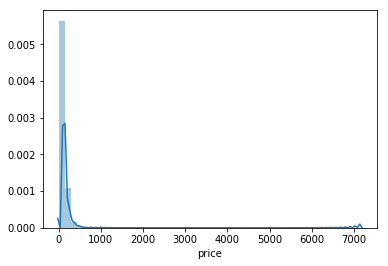

In [56]:
###there's an extremely long tail
sns.distplot(listings['price'])

In [57]:
q = listings["price"].quantile(0.99)
### excluding price outliers
listings = listings[listings["price"] < q]


In [58]:
listings.shape

(52784, 127)

In [59]:
listings.to_csv('clean_listings.csv',index=None)

In [60]:
listings = pd.read_csv('clean_listings.csv')

In [61]:
listings.corr()['review_scores_rating'].sort_values(ascending=False).head()

review_scores_rating           1.000000
review_scores_accuracy         0.734006
review_scores_cleanliness      0.718360
review_scores_value            0.712822
review_scores_communication    0.633385
Name: review_scores_rating, dtype: float64

In [62]:
###theres a tendency for people to overegg negative reviews idf they are very unhappy. so remove low outliers fromreview csofres

for x in ['review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']:
    q = listings[x].quantile(0.01)
    listings = listings[listings[x] > q]



In [63]:
listings.shape

(42293, 127)

In [64]:
listings.corr()['price'].sort_values(ascending=False).head(10)

price                                 1.000000
accommodates                          0.668013
room_type                             0.598024
cleaning_fee                          0.589669
bedrooms                              0.579901
beds                                  0.548899
bathrooms                             0.408051
guests_included                       0.394099
security_deposit                      0.336135
neighbourhood_cleansed_Westminster    0.209997
Name: price, dtype: float64

In [68]:
listings.corr()['price'].sort_values(ascending=False).head(10).index

Index(['price', 'accommodates', 'room_type', 'cleaning_fee', 'bedrooms',
       'beds', 'bathrooms', 'guests_included', 'security_deposit',
       'neighbourhood_cleansed_Westminster'],
      dtype='object')

In [74]:
corr_df = listings[listings.corr()['price'].sort_values(ascending=False).head(10).index].corr()

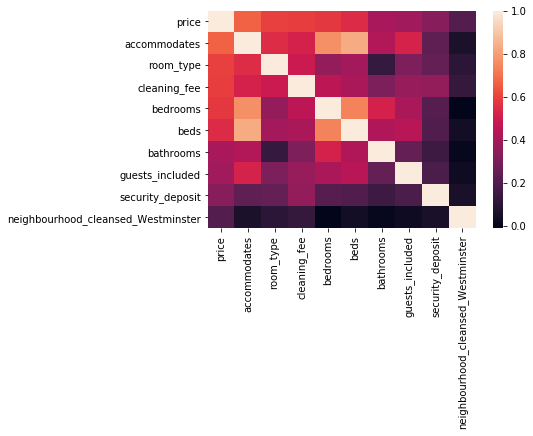

In [75]:
sns.heatmap(corr_df)

In [76]:
listings['price_pp'] = listings['price']/listings['accommodates']
listings.corr()['price_pp'].sort_values(ascending=False).head(10)

price_pp                                         1.000000
price                                            0.513720
room_type                                        0.227689
review_scores_location                           0.208447
neighbourhood_cleansed_Westminster               0.203720
neighbourhood_cleansed_Kensington and Chelsea    0.189828
cleaning_fee                                     0.184412
security_deposit                                 0.157908
new_zip_W                                        0.149982
new_zip_WC                                       0.130792
Name: price_pp, dtype: float64

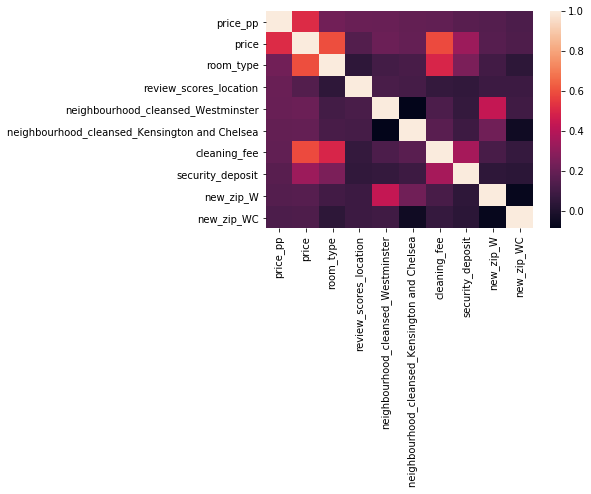

In [77]:
corr_df = listings[listings.corr()['price_pp'].sort_values(ascending=False).head(10).index].corr()
sns.heatmap(corr_df)

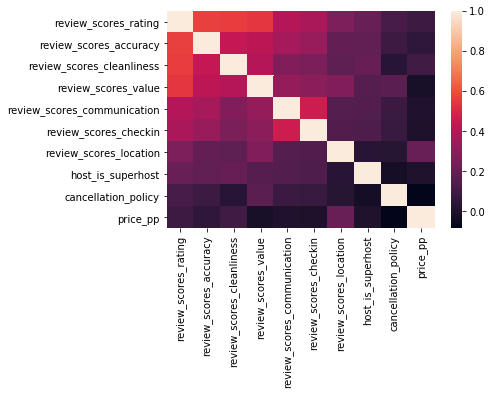

In [89]:
##without the low outliers the rating isnt as dependent 
##on any one indivual skewing score. and other correlations are improved


corr_df = listings[listings.corr()['review_scores_rating'].sort_values(ascending=False).head(10).index].corr()
sns.heatmap(corr_df)


In [79]:
listings.to_csv('clean_listings.csv',index=None)

In [80]:
###given that the price is highly tied to how many beds etc it's probably better to try and predict the price per person
dfprice = listings.drop(columns=['price', 'accommodates'])


In [81]:
###spilt out features and labels 
X = dfprice.drop('price_pp',axis=1)
y= listings['price_pp']

In [82]:
###time to scale the data 
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = X.columns


In [83]:
###test train split 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [84]:

mod = DecisionTreeRegressor(max_depth=8, min_samples_split=15, min_samples_leaf=8)
mod.fit(X_train,y_train)
mod.fit(X_train,y_train)
mod.score(X_train,y_train)

0.3427338798071283

In [85]:
###compare the abs error if we just guessed all price per person to be the mean
from sklearn import metrics
metrics.median_absolute_error(y_test, [y_test.mean()]*len(y_test))

9.43205503153633

In [86]:
### median abs error of test pred
metrics.median_absolute_error(y_test, mod.predict(X_test))

7.272378239044897

<BarContainer object of 10 artists>

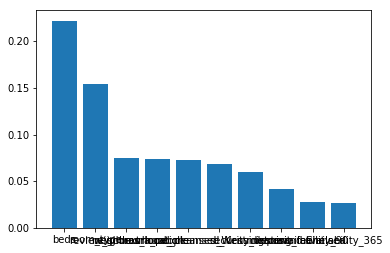

In [87]:

feat_imp = pd.DataFrame(mod.feature_importances_.transpose(), index=X_scaled.columns, columns=['imp'])
feat_imp = feat_imp.sort_values(by=['imp'],ascending=False).head(10)
plt.bar(feat_imp.index, feat_imp['imp'])

In [90]:
listings = pd.read_csv('clean_listings.csv')

In [91]:
feat_imp

,imp
beds,0.221794
room_type,0.153620
review_scores_location,0.074954
extra_people,0.073350
neighbourhood_cleansed_Westminster,0.072786
neighbourhood_cleansed_Kensington and Chelsea,0.068480
security_deposit,0.059765
cleaning_fee,0.042173
availability_90,0.027596
availability_365,0.026707


In [92]:
###spilt out features and labels 
X = dfprice.drop('review_scores_rating',axis=1)
y= listings['review_scores_rating']

In [93]:
###time to scale the data 
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = X.columns

In [94]:
###test train split 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [95]:

mod = DecisionTreeRegressor(max_depth=8, min_samples_split=15, min_samples_leaf=8)
mod.fit(X_train,y_train)
mod.fit(X_train,y_train)
mod.score(X_train,y_train)

0.5900304771272569

In [96]:
mod.score(X_test,y_test)

0.520020146235789

In [97]:
metrics.median_absolute_error(y_test, [y_test.mean()]*len(y_test))

4.40383023998109

In [98]:
metrics.median_absolute_error(y_test, mod.predict(X_test))

1.4423245614035096

<BarContainer object of 10 artists>

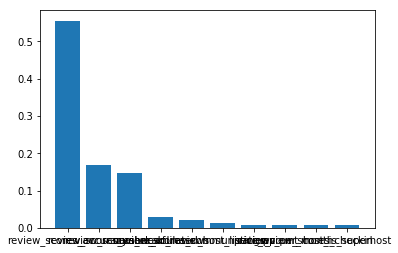

In [99]:

feat_imp = pd.DataFrame(mod.feature_importances_.transpose(), index=X_scaled.columns, columns=['imp'])
feat_imp = feat_imp.sort_values(by=['imp'],ascending=False).head(10)
plt.bar(feat_imp.index, feat_imp['imp'])

In [100]:
feat_imp

,imp
review_scores_accuracy,0.555296
review_scores_value,0.167645
review_scores_cleanliness,0.147269
number_of_reviews,0.030164
review_scores_communication,0.022012
calculated_host_listings_count,0.012605
price_pp,0.008314
reviews_per_month,0.007324
review_scores_checkin,0.007148
host_is_superhost,0.006659


In [101]:
y_test.max()

100.0

In [ ]:
###lets look at what the most popular description words are 

In [104]:
textdf['description']

0        PLEASE CONTACT ME BEFORE BOOKING Homely apartm...
1        The room has a double bed and a single foldawa...
2        My bright double bedroom with a large window h...
3        Open from June 2018 after a 3-year break, we a...
4        Artist house, high ceiling bedrooms, private p...
5        Large, all comforts, 2-bed flat; first floor; ...
6        Big room with double bed/ clean sheets/ clean ...
7        Contemporary design meets classic London in th...
8        A single bedroom in a high-ceilinged, fully-eq...
9        Hi and Welcome home in the heart of Shoreditch...
10       Lovely Family Home available (between 2 and 8 ...
11       The name says it all, it really is a restful r...
12       Walking distance to Twickenham Stadium, 35 min...
13       Super cool, super central, super equipped and ...
14       Bright, large dbl room with a very high ceilin...
15       3 Bed House with garden close to Thames river ...
16       This room is located on the ground floor of th.

In [105]:
##drop nulls 
textdf.dropna(subset=['description'],inplace=True)

In [106]:

def string_clean(x):
    '''function takes a string x and returns only the text '''
    #return re.sub(r"[^A-Za-z]+", '', x)
    return re.sub(r'[^\w\s]','',x)
   

textdf['new_desc'] = textdf['description'].apply(string_clean)
#listings.drop(columns=['zipcode'], inplace=True)

In [107]:
textdf['new_desc']

0        PLEASE CONTACT ME BEFORE BOOKING Homely apartm...
1        The room has a double bed and a single foldawa...
2        My bright double bedroom with a large window h...
3        Open from June 2018 after a 3year break we are...
4        Artist house high ceiling bedrooms private par...
5        Large all comforts 2bed flat first floor lift ...
6        Big room with double bed clean sheets clean to...
7        Contemporary design meets classic London in th...
8        A single bedroom in a highceilinged fullyequip...
9        Hi and Welcome home in the heart of Shoreditch...
10       Lovely Family Home available between 2 and 8 p...
11       The name says it all it really is a restful ro...
12       Walking distance to Twickenham Stadium 35 min ...
13       Super cool super central super equipped and su...
14       Bright large dbl room with a very high ceiling...
15       3 Bed House with garden close to Thames river ...
16       This room is located on the ground floor of th.

In [108]:
###get common stopwords 
swords = list(stopwords.words('english'))

In [109]:
###create a single joined of all words together
wcount = pd.Series(' '.join(textdf["new_desc"]).lower().split()).value_counts()


In [110]:
###bool of whether the word is a stop word (could be refactored)
log_assess = [x not in swords for x in wcount.index]

In [111]:
####return frequencies 
freqs = wcount[log_assess]

In [120]:
###create dict
d = freqs.to_dict()

In [124]:
###return only the dict
d = d[0]

In [103]:
from wordcloud import WordCloud

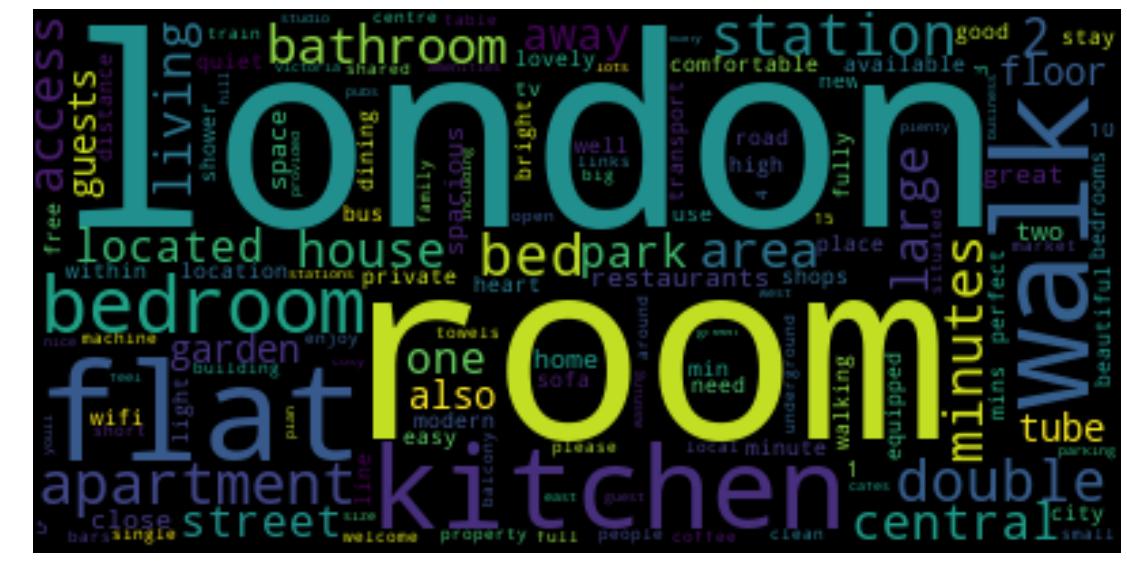

In [126]:
###generate worldcloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()